In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Read each CSV file
train_df = pd.read_csv(os.path.join('../Data', "train_data.csv"))
undersampled_train_df = pd.read_csv(os.path.join('../Data', "undersampled_train_data.csv"))
oversampled_train_df = pd.read_csv(os.path.join('../Data', "oversampled_train_data.csv"))
extracted_features_train_df = pd.read_csv(os.path.join('../Data', "extracted_features_train_data.csv"))
extracted_features_undersampled_train_df = pd.read_csv(os.path.join('../Data', "extracted_features_undersampled_train_data.csv"))
extracted_features_oversampled_train_df = pd.read_csv(os.path.join('../Data', "extracted_features_oversampled_train_data.csv"))
test_df = pd.read_csv(os.path.join('../Data', "test_data.csv"))

In [3]:
N_SPLITS = 3

# Apply on the original data

In [4]:
X_train = train_df.drop('Class', axis=1).values
y_train = train_df['Class'].values

# Define KNN hyperparameters to search
knn_params = {
    'n_neighbors': [5, 7, 9],
    'weights': ['distance'],
}

# Set up GridSearchCV with KNN
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train KNN with cross-validation
grid_knn.fit(X_train, y_train)

# Best KNN model from the grid search
knn_model = grid_knn.best_estimator_

print("Best Estimator: ", knn_model)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Estimator:  KNeighborsClassifier(n_neighbors=9, weights='distance')


In [5]:
# results of grid search CV
cv_results = pd.DataFrame(grid_knn.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.026356,0.003267,7.996644,1.054228,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.908937,0.908237,0.931203,0.916126,0.010665,3,1.0,1.0,1.0,1.0,0.0
1,0.024673,0.000736,7.908990,1.130244,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.916483,0.908203,0.934988,0.919891,0.011198,2,1.0,1.0,1.0,1.0,0.0
2,0.025082,0.001031,7.064389,0.071691,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.916443,0.908172,0.938771,0.921129,0.012924,1,1.0,1.0,1.0,1.0,0.0


In [6]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_knn.best_score_)
print(grid_knn.best_estimator_)

Best roc_auc:- 0.9211287221011218
KNeighborsClassifier(n_neighbors=9, weights='distance')


In [7]:
# Best score with best params
best_score = grid_knn.best_score_
best_params = grid_knn.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9211287221011218 with parameters {'n_neighbors': 9, 'weights': 'distance'}


In [8]:
knn = KNeighborsClassifier(**best_params)
original_best_knn_model = knn.fit(X_train, y_train)
y_train_pred = original_best_knn_model.predict(X_train)

In [9]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[227451      0]
 [     0    394]]


In [10]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 1.0
Percision: 1.0
F1-Score: 1.0
Accuracy: 1.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845



In [11]:
# ROC Curve function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

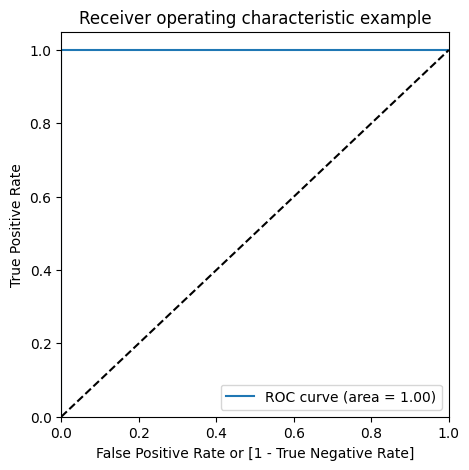

In [12]:
# Predicted probability
y_train_pred_proba = original_best_knn_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [13]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(original_best_knn_model, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9994
test_precision: 0.8949
test_recall: 0.7665
test_f1: 0.8253
test_roc_auc: 0.9211


### Consider the most important features only (V3, V4, V7, V10, V12,V14, V16, V17, V18) on the original data

In [14]:
X_train = extracted_features_train_df.drop('Class', axis=1).values
y_train = extracted_features_train_df['Class'].values

# Define KNN hyperparameters to search
knn_params = {
    'n_neighbors': [5, 7, 9],
    'weights': ['distance'],
}

# Set up GridSearchCV with KNN
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train KNN with cross-validation
grid_knn.fit(X_train, y_train)

# Best KNN model from the grid search
knn_model = grid_knn.best_estimator_

print("Best Estimator: ", knn_model)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Estimator:  KNeighborsClassifier(weights='distance')


In [15]:
# results of grid search CV
cv_results = pd.DataFrame(grid_knn.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.295340,0.006488,9.439356,0.221657,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.919738,0.920359,0.935011,0.925036,0.007058,1,1.0,1.0,1.0,1.0,0.0
1,0.272798,0.006561,10.537440,0.221380,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.919706,0.920330,0.934998,0.925011,0.007066,2,1.0,1.0,1.0,1.0,0.0
2,0.284194,0.016437,12.593361,0.539072,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.919673,0.920302,0.934968,0.924981,0.007066,3,1.0,1.0,1.0,1.0,0.0


In [16]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_knn.best_score_)
print(grid_knn.best_estimator_)

Best roc_auc:- 0.9250361141651745
KNeighborsClassifier(weights='distance')


In [17]:
# Best score with best params
best_score = grid_knn.best_score_
best_params = grid_knn.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9250361141651745 with parameters {'n_neighbors': 5, 'weights': 'distance'}


In [18]:
knn = KNeighborsClassifier(**best_params)
original_best_knn_model_v2 = knn.fit(X_train, y_train)
y_train_pred = original_best_knn_model_v2.predict(X_train)

In [19]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[221542      0]
 [     0    394]]


In [20]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 1.0
Percision: 1.0
F1-Score: 1.0
Accuracy: 1.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    221542
           1       1.00      1.00      1.00       394

    accuracy                           1.00    221936
   macro avg       1.00      1.00      1.00    221936
weighted avg       1.00      1.00      1.00    221936



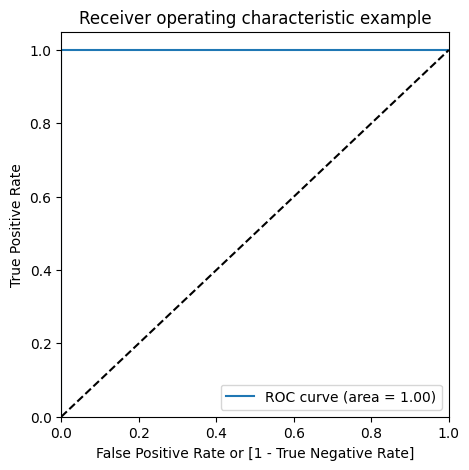

In [21]:
# Predicted probability
y_train_pred_proba = original_best_knn_model_v2.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [22]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(original_best_knn_model_v2, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9996
test_precision: 0.9529
test_recall: 0.8148
test_f1: 0.8781
test_roc_auc: 0.9250


# Apply on the under-sampled data

In [23]:
X_train = undersampled_train_df.drop('Class', axis=1).values
y_train = undersampled_train_df['Class'].values

# Define KNN hyperparameters to search
knn_params = {
    'n_neighbors': [5, 7, 9],
    'weights': ['distance'],
}

# Set up GridSearchCV with KNN
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train KNN with cross-validation
grid_knn.fit(X_train, y_train)

# Best KNN model from the grid search
knn_model = grid_knn.best_estimator_

print("Best Estimator: ", knn_model)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Estimator:  KNeighborsClassifier(n_neighbors=9, weights='distance')


In [24]:
# results of grid search CV
cv_results = pd.DataFrame(grid_knn.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.000797,0.000336,0.004018,0.000160,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.959230,0.972560,0.975176,0.968989,0.006983,3,1.0,1.0,1.0,1.0,0.0
1,0.000576,0.000014,0.004218,0.000211,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.960039,0.975075,0.978702,0.971272,0.008080,2,1.0,1.0,1.0,1.0,0.0
2,0.000553,0.000139,0.003600,0.000320,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.962237,0.974786,0.978061,0.971695,0.006820,1,1.0,1.0,1.0,1.0,0.0


In [25]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_knn.best_score_)
print(grid_knn.best_estimator_)

Best roc_auc:- 0.9716945399452247
KNeighborsClassifier(n_neighbors=9, weights='distance')


In [26]:
# Best score with best C
best_score = grid_knn.best_score_
best_params = grid_knn.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9716945399452247 with parameters {'n_neighbors': 9, 'weights': 'distance'}


In [27]:
knn = KNeighborsClassifier(**best_params)
undersampled_best_knn_model = knn.fit(X_train, y_train)
y_train_pred = undersampled_best_knn_model.predict(X_train)

In [28]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[394   0]
 [  0 394]]


In [29]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 1.0
Percision: 1.0
F1-Score: 1.0
Accuracy: 1.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       394

    accuracy                           1.00       788
   macro avg       1.00      1.00      1.00       788
weighted avg       1.00      1.00      1.00       788



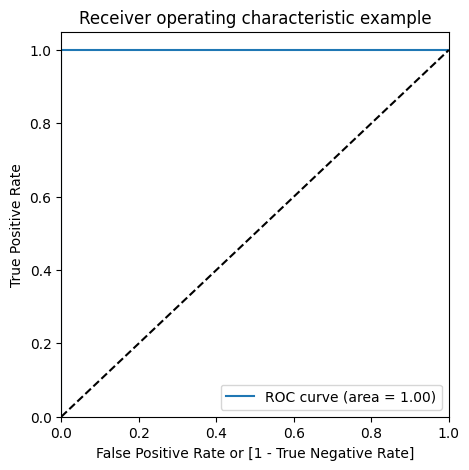

In [30]:
# Predicted probability
y_train_pred_proba = undersampled_best_knn_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [31]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(undersampled_best_knn_model, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9366
test_precision: 0.9943
test_recall: 0.8782
test_f1: 0.9326
test_roc_auc: 0.9717


### Consider the most important features only (V3, V4, V7, V10, V12,V14, V16, V17, V18) on the undersampled data

In [32]:
X_train = extracted_features_undersampled_train_df.drop('Class', axis=1).values
y_train = extracted_features_undersampled_train_df['Class'].values

# Define KNN hyperparameters to search
knn_params = {
    'n_neighbors': [5, 7, 9],
    'weights': ['distance'],
}

# Set up GridSearchCV with KNN
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train KNN with cross-validation
grid_knn.fit(X_train, y_train)

# Best KNN model from the grid search
knn_model = grid_knn.best_estimator_

print("Best Estimator: ", knn_model)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Estimator:  KNeighborsClassifier(n_neighbors=7, weights='distance')


In [33]:
# results of grid search CV
cv_results = pd.DataFrame(grid_knn.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.000884,0.000252,0.003344,0.000377,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.953362,0.968810,0.982914,0.968362,0.012069,3,1.0,1.0,1.0,1.0,0.0
1,0.000666,0.000023,0.002927,0.000277,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.961914,0.968154,0.983391,0.971153,0.009021,1,1.0,1.0,1.0,1.0,0.0
2,0.000641,0.000027,0.002816,0.000080,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.959399,0.966066,0.985538,0.970334,0.011090,2,1.0,1.0,1.0,1.0,0.0


In [34]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_knn.best_score_)
print(grid_knn.best_estimator_)

Best roc_auc:- 0.9711528904262087
KNeighborsClassifier(n_neighbors=7, weights='distance')


In [35]:
# Best score with best params
best_score = grid_knn.best_score_
best_params = grid_knn.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9711528904262087 with parameters {'n_neighbors': 7, 'weights': 'distance'}


In [36]:
knn = KNeighborsClassifier(**best_params)
undersampled_best_knn_model_v2 = knn.fit(X_train, y_train)
y_train_pred = undersampled_best_knn_model_v2.predict(X_train)

In [37]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[384   0]
 [  0 394]]


In [38]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 1.0
Percision: 1.0
F1-Score: 1.0
Accuracy: 1.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       384
           1       1.00      1.00      1.00       394

    accuracy                           1.00       778
   macro avg       1.00      1.00      1.00       778
weighted avg       1.00      1.00      1.00       778



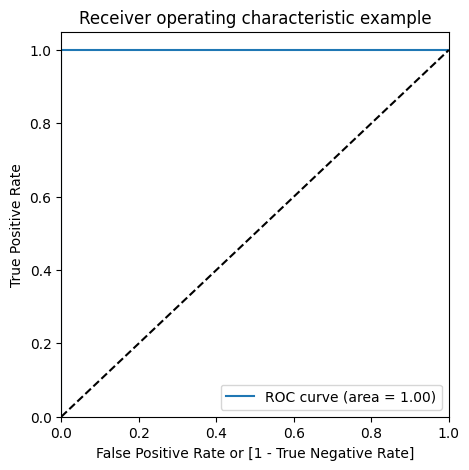

In [39]:
# Predicted probability
y_train_pred_proba = undersampled_best_knn_model_v2.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [40]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(undersampled_best_knn_model_v2, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9332
test_precision: 0.9804
test_recall: 0.8858
test_f1: 0.9306
test_roc_auc: 0.9712


# Apply on the over-sampled data

In [41]:
X_train = oversampled_train_df.drop('Class', axis=1).values
y_train = oversampled_train_df['Class'].values

# Define KNN hyperparameters to search
knn_params = {
    'n_neighbors': [5, 7, 9],
    'weights': ['distance'],
}

# Set up GridSearchCV with KNN
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train KNN with cross-validation
grid_knn.fit(X_train, y_train)

# Best KNN model from the grid search
knn_model = grid_knn.best_estimator_

print("Best Estimator: ", knn_model)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Estimator:  KNeighborsClassifier(n_neighbors=9, weights='distance')


In [42]:
# results of grid search CV
cv_results = pd.DataFrame(grid_knn.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.050354,0.005265,26.082762,1.178806,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.999505,0.999466,0.999585,0.999519,0.000049,3,1.0,1.0,1.0,1.0,0.0
1,0.046275,0.002106,27.477476,1.412545,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.999532,0.999479,0.999591,0.999534,0.000046,2,1.0,1.0,1.0,1.0,0.0
2,0.046217,0.000711,31.246637,2.455377,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.999532,0.999479,0.999611,0.999541,0.000054,1,1.0,1.0,1.0,1.0,0.0


In [43]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_knn.best_score_)
print(grid_knn.best_estimator_)

Best roc_auc:- 0.9995405586737592
KNeighborsClassifier(n_neighbors=9, weights='distance')


In [44]:
# Best score with best C
best_score = grid_knn.best_score_
best_params = grid_knn.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9995405586737592 with parameters {'n_neighbors': 9, 'weights': 'distance'}


In [45]:
knn = KNeighborsClassifier(**best_params)
oversampled_best_knn_model = knn.fit(X_train, y_train)
y_train_pred = oversampled_best_knn_model.predict(X_train)

In [46]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[227451      0]
 [     0 227451]]


In [47]:
# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# classification_report
print(classification_report(y_train, y_train_pred))

Accuracy: 1.0
Sensitivity(Recall): 1.0
Percision: 1.0
Specificity: 1.0
F1-Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



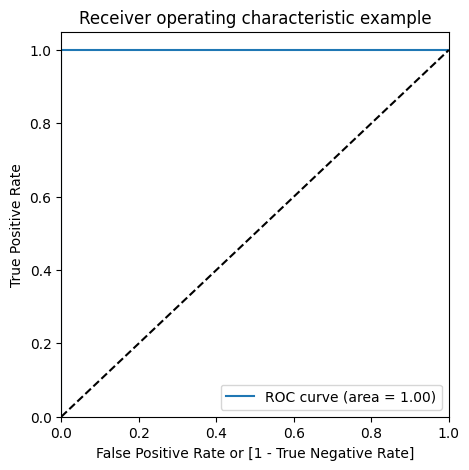

In [48]:
# Predicted probability
y_train_pred_proba = oversampled_best_knn_model.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [49]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(oversampled_best_knn_model, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9979
test_precision: 0.9957
test_recall: 1.0000
test_f1: 0.9979
test_roc_auc: 0.9995


### Consider the most important features only (V3, V4, V7, V10, V12,V14, V16, V17, V18) on the oversampled data

In [51]:
X_train = extracted_features_oversampled_train_df.drop('Class', axis=1).values
y_train = extracted_features_oversampled_train_df['Class'].values

# Define KNN hyperparameters to search
knn_params = {
    'n_neighbors': [5, 7, 9],
    'weights': ['distance'],
}

# Set up GridSearchCV with KNN
grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='roc_auc',
    cv=N_SPLITS,
    verbose=1,
    return_train_score=True
)

# Train KNN with cross-validation
grid_knn.fit(X_train, y_train)

# Best KNN model from the grid search
knn_model = grid_knn.best_estimator_

print("Best Estimator: ", knn_model)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Estimator:  KNeighborsClassifier(n_neighbors=9, weights='distance')


In [52]:
# results of grid search CV
cv_results = pd.DataFrame(grid_knn.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.651666,0.030353,9.533965,0.386008,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.999194,0.999201,0.999072,0.999156,0.000059,3,1.0,1.0,1.0,1.0,0.0
1,0.631893,0.031227,10.569365,0.079207,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.999214,0.999248,0.999113,0.999192,0.000058,2,1.0,1.0,1.0,1.0,0.0
2,0.613313,0.023411,11.952795,0.254471,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.999262,0.999282,0.999146,0.999230,0.000060,1,1.0,1.0,1.0,1.0,0.0


In [53]:
# Printing the optimal sensitivity score and hyperparameters
print("Best roc_auc:-", grid_knn.best_score_)
print(grid_knn.best_estimator_)

Best roc_auc:- 0.9992300484894464
KNeighborsClassifier(n_neighbors=9, weights='distance')


In [54]:
# Best score with best params
best_score = grid_knn.best_score_
best_params = grid_knn.best_params_

print("The highest test roc_auc is {0} with parameters {1}".format(best_score, best_params))

The highest test roc_auc is 0.9992300484894464 with parameters {'n_neighbors': 9, 'weights': 'distance'}


In [55]:
knn = KNeighborsClassifier(**best_params)
oversampled_best_knn_model_v2 = knn.fit(X_train, y_train)
y_train_pred = oversampled_best_knn_model_v2.predict(X_train)

In [55]:
confusion = confusion_matrix(y_train, y_train_pred)
print(confusion)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[221542      0]
 [     0 227451]]


In [56]:
# Sensitivity
print("Sensitivity(Recall):", recall_score(y_train, y_train_pred))

# Percision
print("Percision:", precision_score(y_train, y_train_pred))

# F1 score
print("F1-Score:", f1_score(y_train, y_train_pred))

# Accuracy
print("Accuracy:", accuracy_score(y_train, y_train_pred))

# Specificity
print("Specificity:", TN / float(TN+FP))

# classification_report
print(classification_report(y_train, y_train_pred))

Sensitivity(Recall): 1.0
Percision: 1.0
F1-Score: 1.0
Accuracy: 1.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    221542
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    448993
   macro avg       1.00      1.00      1.00    448993
weighted avg       1.00      1.00      1.00    448993



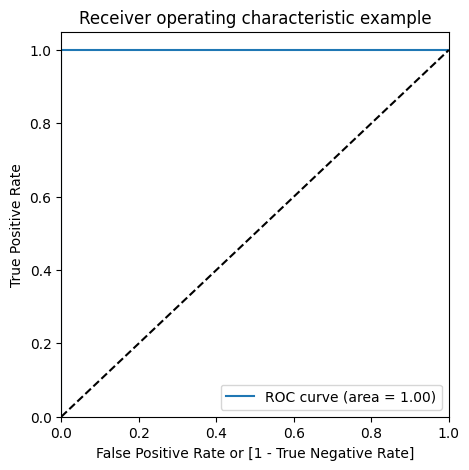

In [57]:
# Predicted probability
y_train_pred_proba = oversampled_best_knn_model_v2.predict_proba(X_train)[:,1]
# Plot the ROC curve
draw_roc(y_train, y_train_pred_proba)

In [58]:
# Define scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Perform cross-validation
cv_results = cross_validate(oversampled_best_knn_model_v2, X_train, y_train, cv=N_SPLITS, scoring=scoring)

# Display average of each metric
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f}")

test_accuracy: 0.9967
test_precision: 0.9935
test_recall: 1.0000
test_f1: 0.9967
test_roc_auc: 0.9992
